# Testbench Reporting Notebook

# Imports

In [1]:
# Imports
import os, glob, yaml
from fnmatch import fnmatch
import numpy as np
import pandas as pd
import ruamel.yaml as ry
import matplotlib.pyplot as plt
from openfast_io import FileTools

pd.options.mode.copy_on_write = True
pd.options.display.float_format = '{:.2f}'.format




# Helper functions
will remain here until they have stablized.

In [2]:
def create_summary_table(aep_info, char_loads, char_load_cases, char_load_channels, dd, ds, del_channels, labels):
    """
    Create a summary table DataFrame with AEP, characteristic loads, and DELs.
    Returns a DataFrame with percent change columns.
    """
    # Collect AEP information into a summary table dictionary
    summary_table_dict = {}
    summary_table_dict['AEP (GWh)'] = [aep_info[i]['AEP']/1e6 for i in range(len(aep_info))]

    # Collect characteristic loads for each DLC case and channel
    for cl in char_loads:
        for case in char_load_cases:
            for channel in char_load_channels:
                l = f'DLC {case} Char. {channel} Load'
                if l not in summary_table_dict:
                    summary_table_dict[l] = []
                summary_table_dict[l].append(cl[case][channel]['characteristic_load'])

    # Collect DELs for each channel, case
    cases = [index for index, element in enumerate(dd[0].index) if '1.1' in element]
    cases = dd[0].index[cases]
    for ds_i in ds:
        for channel in del_channels:
            l = f'{channel} DEL'
            if l not in summary_table_dict:
                summary_table_dict[l] = []
            summary_table_dict[l].append(ds_i[channel])

    # Set up dataframe for summary table
    summ_df = pd.DataFrame(summary_table_dict).T
    summ_df.columns = labels

    # Add percent change from baseline controller
    baseline_label = labels[0]
    for l in summ_df.columns[1:]:
        perc_change = 100 * (summ_df[l] / summ_df[baseline_label] - 1)
        change_label = f'{l} (percent change)'
        summ_df[change_label] = perc_change

    return summ_df

def plot_binned_data(dfs, channels=None, fig=None, labels = None):
    """
    Plots time series from defined channels within the dataframe (df, binned_*.p).
    """

    if not type(dfs) == list:
        dfs = [dfs]
    
    if channels is None:
        channels = ['RootMyb1','TwrBsMyt','LSSTipMya','YawBrMyp']

    if fig is None:
        fig, ax = plt.subplots(len(channels), 1, figsize=(10,3*len(channels)), tight_layout=True)
    else: 
        ax = fig.axes
    if len(ax) != len(channels):
        raise ValueError(f"Figure provided does not have the same number of axes as channels. Expected: {len(channels)}, actual: {len(axes)}.")

    if labels is None:
        labels = []
        for k in range(len(dfs)):
            labels.append('Controller '+str(k+1))

    for n, channel in enumerate(channels):
        for k, df in enumerate(dfs):
            ax[n].plot(
                np.sqrt(df['Wind1VelX']**2 + df['Wind1VelY']**2),
                abs(df[channel]),
                label=labels[k],
                marker='.',
                markersize=.75,
                alpha=0.75,
                linestyle='None'
            )
        # ax[n].axhline(y=np.max(abs(df[channel])), color='C'+str(k), linestyle='--', label='_')
        ax[n].set_xlabel('Wind speed')
        ax[n].set_ylabel(channel)
        ax[n].grid()
        ax[n].set_xlim([0, 30])
        if len(dfs) > 1:
            ax[0].legend()
    
    dt = df['Time'].iloc[1] - df['Time'].iloc[0]
    fig.set_size_inches(7,len(channels)*3)
    return fig, ax, dt

def plot_characteristic_loads(data, cases=None, channels=None, labels = None):
    """
    Plots characteristic loads from yaml file for defined channels and DLC cases.
    """

    if not type(data) == list:
        data = [data]

    if cases is None:
        cases = ['1.1','1.3']
    
    if channels is None:
        channels = ['RootMyb1','TwrBsMyt','LSSTipMya','YawBrMyp']

    if labels is None:
        labels = []
        for k in range(len(data)):
            labels.append('Controller '+str(k+1))

    for case in cases:
        fig, ax = plt.subplots(len(channels), 1, figsize=(7,2*len(channels)), tight_layout=True)

        ax[0].set_title(f"DLC {case}")
        for n, channel in enumerate(channels):
            for k, datum in enumerate(data):
                ax[n].scatter(datum[case][channel]['wind_speed'], datum[case][channel]['load_values'], label=labels[k])
                ax[n].axhline(y=datum[case][channel]['characteristic_load'], color='C'+str(k), linestyle='--',label='_')
            ax[n].set_xlabel('Wind speed')
            ax[n].set_ylabel(channel)
            ax[n].grid()
        if len(data) > 1:
            ax[0].legend()

    return fig, ax


# Function for reading case matrix
def read_cm(fname_case_matrix):
    cm_dict = FileTools.load_yaml(fname_case_matrix, package=1)
    cnames = []
    for c in list(cm_dict.keys()):
        if isinstance(c,ry.comments.CommentedKeySeq):
            cnames.append(tuple(c))
        else:
            cnames.append(c)

    cm = pd.DataFrame(cm_dict, columns=cnames)
    
    if ('DLC','Label') in cm:

        cm[('DLC','Label')].unique()

        dlc_inds = {}

        for dlc in cm[('DLC','Label')].unique():
            dlc_inds[dlc] = cm[('DLC','Label')] == dlc

        return cm, dlc_inds
    
    else:
        return cm, None

def plot_timeseries(summary_folders,cases_to_plot, channels=None,labels=None):
    if channels is None:
        channels = ["Wind1VelX_[m/s]", "GenTq_[kN-m]", "BldPitch1_[deg]", "RtSpeed_[rpm]"]
    
    if labels is None:
        labels = []
        for k in range(len(data)):
            labels.append('Controller '+str(k+1))
    
    for case in cases_to_plot:
        fig, axs = plt.subplots(len(channels), 1)
        if len(channels) == 1:
            axs = [axs]
        axs = axs.flatten()
        for summary_folder in summary_folders:
            dfdlc = pd.read_pickle(
                os.path.join(summary_folder,f"timeseries/{case}.p")
            )
            for i_chan, chan in enumerate(channels):

                if chan not in dfdlc.columns:
                    print(f"Channel {chan} not found in {case} timeseries data.")
                    continue
                axs[i_chan].plot(dfdlc["Time"], dfdlc[chan.split("_")[0]], label=case)
                axs[i_chan].set_ylabel(chan.replace("_", "\n"))
                axs[i_chan].grid(True)

        fig.set_figheight(2.5 * len(channels))
        fig.set_figwidth(7)
        fig.align_ylabels()
        axs[0].set_title(
            f"{case}"
        )
        axs[0].legend(labels)
        axs[-1].set_xlabel("Time")
    # return fig, axs
    

def stability_analysis(summary_folders, case_matrix, labels, case_index = 0):
    # NOTE: This code assumes that same dlcs has been run in all the cases.
    casematrix = case_matrix[case_index]
    
    allrampdlcs = []
    allstepdlcs = []
    allsteadystepdlcs = []
    allsteadydlcs = []

    for dlc, dlctype in casematrix["DLC"].items():
        match dlctype:
            case "Ramp":
                allrampdlcs.append(dlc)
            case "Step":
                allstepdlcs.append(dlc)
                if casematrix[('InflowWind', 'WindType')][dlc] == 2:
                    allsteadystepdlcs.append(dlc)
            case "Steady":
                allsteadydlcs.append(dlc)
    if allrampdlcs:
        plot_stability_timeseries(summary_folders, allrampdlcs, labels)
    if allstepdlcs:
        plot_stability_timeseries(summary_folders, allstepdlcs, labels)
    if allsteadydlcs:
        plot_stability_timeseries(summary_folders, allsteadydlcs, labels)
    if allsteadystepdlcs:  # TODO: disabled for now, use case_matrix to determine step time
        measure_stepresponse(summary_folders,casematrix,allsteadystepdlcs)



def plot_stability_timeseries(summary_folders, alldlcs, labels):
    channels = ["Wind1VelX_[m/s]", "GenTq_[kN-m]", "BldPitch1_[deg]", "RtSpeed_[rpm]"]
    for dlc in alldlcs:
        fig, axs = plt.subplots(len(channels), 1)
        if len(channels) == 1:
            axs = [axs]
        axs = axs.flatten()

        for case in summary_folders:
            dfdlc = pd.read_pickle(
                os.path.join(case, f"timeseries/{dlc}.p")
            )
            for i_chan, chan in enumerate(channels):
                axs[i_chan].plot(dfdlc["Time"], dfdlc[chan.split("_")[0]], label=case)
                axs[i_chan].set_ylabel(chan.replace("_", "\n"))
                axs[i_chan].grid(True)

        fig.set_figheight(2 * len(channels))
        fig.set_figwidth(7)
        axs[0].set_title(
            f"{dlc.split('_')[0][3:].lower()} inflow with {dlc}"
        )
        axs[0].legend(labels)
        axs[-1].set_xlabel("Time")
        # fig.savefig(f"{dlc}_StabilityAnalysis.png")

def measure_stepresponse(summary_folders,casematrix,alldlcs):
    for case in summary_folders:

        for dlc in alldlcs:

            # Read step wind information
            windfile_step = casematrix[('InflowWind', 'FileName_Uni')][dlc]


            with open(os.path.join(case,'wind',windfile_step),'r') as f:
                winddata = f.readlines()
            steptime = float(winddata[7].split()[0])

            dfdlc = pd.read_pickle(
                os.path.join(case, f"timeseries/{dlc}.p")
            )
            channels = ["GenTq_[kN-m]", "BldPitch1_[deg]", "RtSpeed_[rpm]"]
            time = dfdlc['Time']
            for chan in channels:
                y = dfdlc[chan.split("_")[0]]

                # Steady state value
                yss = np.mean(y[time>steptime])

                # Overshoot
                overshoot = (np.max(y) - yss) / yss * 100

                # Rise time
                y_10perc = 0.1 * yss
                y_90perc = 0.9 * yss
                rise_start = time[np.where(y >= y_10perc)[0][0]]
                rise_end = time[np.where(y >= y_90perc)[0][0]]
                rise_time = rise_end - rise_start

                # Settling time
                # within_tol_2percent = np.abs(y - yss) <= 0.02 * yss
                # settling_time_2percent = time[np.where(within_tol_2percent)[0][-1]] if np.all(within_tol_2percent) else time[-1]
                print(f"for chan = {chan}, overshoot is {overshoot}, risetime is {rise_time}")# , settline_time is {settling_time_2percent}")


def plot_dels_at_ws(dfs, sumfs, dss, channels = None, cases = None, fig = None, labels = None):
    """
    Plot DELs (from df DELs file) for different wind speeds (from sumf summary file).
    """

    if not type(dfs) == list:
        dfs = [dfs]    
    if not type(sumfs) == list:
        sumfs = [sumfs]  
    if not type(dss) == list:
        dss = [dss]

    if channels is None:
        channels = ['RootMyb1','TwrBsMyt','LSSTipMya','YawBrMyp']

    if fig is None:
        fig, ax = plt.subplots(len(channels), 1, figsize=(7,3*len(channels)), tight_layout=True)
    else: 
        ax = fig.axes
    if len(ax) != len(channels):
        raise ValueError(f"Figure provided does not have the same number of axes as channels. Expected: {len(channels)}, actual: {len(ax)}.")
    
    if labels is None:
        labels = []
        for k in range(len(dfs)):
            labels.append('Controller '+str(k+1))

    ws = []

    for sumf in sumfs:
        ws.append(np.sqrt( sumf.loc[cases]['Wind1VelX']['mean'].values**2 + sumf.loc[cases]['Wind1VelY']['mean'].values**2 ))
    for n, channel in enumerate(channels):
        for k, df in enumerate(dfs):
            ax[n].scatter(ws[k], abs(df.loc[cases][channel]), label=f'{labels[k]}: Sim. DEL')
            ax[n].axhline(y=dss[k][channel], color='C'+str(k), linestyle='-', label=f'{labels[k]}: Lifetime DEL')   # Lifeteime DELs
        
        ax[n].set_xlabel('Wind speed (m/s)')
        ax[n].set_ylabel(channel)
        ax[n].grid()

    # Plot distribution of wind speeds
    dist_prob = []
    dist_ws = []
    for ds in dss:
        _, unique_idx = np.unique(ds['wind_speeds'], return_index=True)
        dist_prob.append(np.array(ds['probability'])[unique_idx])
        dist_ws.append(np.array(ds['wind_speeds'])[unique_idx])

    
    for i_ax, a in enumerate(ax):   # for each axis
        ymax = np.max(a.get_ylim())  # Get y limits for the first axis
        
        for n, (prob, ws) in enumerate(zip(dist_prob, dist_ws)):  # for each controller
            ax[i_ax].plot(ws, 0.5 * prob * ymax / np.max(prob), label=f'{labels[k]}: Scaled dist.', color='C'+str(n), linestyle=':')


    ax[0].legend()

    return dist_prob, dist_ws

    



def parse_freq_string(freq_string):
    b = freq_string.replace('[','').replace(']','').split(',')
    return [float(bb) for bb in b]


def report_psd_ranking(psd_summ, channels_to_analyze, n_largest=4, sort_index=0):
    """
    Reports the n_largest PSD values for each channel and frequency from the psd_summ DataFrame.
    psd_summ: List of DataFrames, each containing PSD values for different controllers/channels/frequencies.
    channels_to_analyze: List of channels to analyze.
    n_largest: Number of largest values to report.
    sort_index: Index of the column to sort by when reporting.
    """

    b = []  # List to store series for each controller/channel/frequency
    for i, psd_summ_i in enumerate(psd_summ):
        for chan in channels_to_analyze:
            for col in psd_summ_i[chan].columns:
                a = psd_summ_i[chan][col]  # Series of PSD values for this channel/frequency
                b.append(a)

                # When at the last controller, combine all into a DataFrame and print sorted results
                if i == len(psd_summ)-1:  # last case/controller
                    fdf = pd.DataFrame({l: s for l, s in zip(labels, b)})  # Combine all controllers into one DataFrame

                    print(f'{n_largest} highest cases for {chan} at f = {col}')
                    print(fdf.sort_values(by=labels[sort_index], ascending=False).head(n_largest))
                    print('')

def plot_psd_comparison(summary_folders, cases_to_plot, channels):
    """
    Plot PSD comparison for given cases and channels across multiple summary folders.
    """
    psd_folders = [os.path.join(folder, 'psds') for folder in summary_folders]

    for case_name in cases_to_plot:
        psd_df = []
        psd_summ = []
        for summary_folder, psd_folder in zip(summary_folders, psd_folders):
            psd_df.append(pd.read_pickle(os.path.join(psd_folder, f'{case_name}.p')))
            psd_summ.append(pd.read_pickle(os.path.join(summary_folder, 'psd_summary.p')))

        fig, axs = plt.subplots(len(channels), 1, sharex=True)
        fig.set_size_inches(7, 7)
        for ax, chan in zip(axs, channels):
            yl = None
            for i, (psd_df_i, psd_summ_i) in enumerate(zip(psd_df, psd_summ)):
                ax.loglog(psd_df_i[chan])
                sum_data = psd_summ_i.loc[case_name][chan]
                yl = ax.get_ylim()
                for item in sum_data.items():
                    freqs = parse_freq_string(item[0])
                    data = item[1]
                    if len(freqs) > 1:
                        ax.fill_betweenx(yl, freqs[0], freqs[1], alpha=0.1, color='k')
                        x = np.mean(np.array(freqs))
                    else:
                        ax.axvline(freqs[0], 0, 1)
                        x = freqs[0]
                    ax.plot(x, data, 'x', color='C'+str(i))
            ax.set_ylabel(chan)
            if yl is not None:
                ax.set_ylim(yl)
        axs[-1].set_xlabel('Freq. (Hz)')
        fig.suptitle(case_name)


def plot_aep(aep_info, ss, cm, labels):
    """
    Plot AEP power curves and probability distributions for each controller.
    summary_folders: List of folders containing summary data.
    ss: List of DataFrames containing summary statistics.
    cm: DataFrame containing case matrix information.
    labels: List of labels for each controller.
    """
    
    import matplotlib.pyplot as plt
    AEP_title = ''
    prob_dist = []
    for i, summary_folder in enumerate(summary_folders):

        # Reduce summary stats to AEP relevant cases
        ind_aep = np.array(cm[i]['DLC'] == 'AEP')
        ss_aep = ss[i].loc[ind_aep]

        # Unpack AEP information
        mean_power = ss_aep['GenPwr']['mean']
        ws_i = ss_aep['Wind1VelX']['mean']
        aep_ws = aep_info[i]['mean_wind_speeds']

        # Map each ws_i value to the nearest aep_ws value
        ws_i_mapped = ws_i.apply(lambda x: aep_ws[np.abs(np.array(aep_ws) - x).argmin()])
        ss_aep['AEP_WindSpeed'] = ws_i_mapped

        # Compute mean power for each wind speed in AEP power curve
        grouped = ss_aep.groupby('AEP_WindSpeed')
        mean_power_ws = []
        for ws, group in grouped:
            mean_power_ws.append(group['GenPwr']['mean'].mean())

        aep_info[i]['mean_power'] = mean_power_ws

        # Scale the probability distribution for plotting
        prob_dist.append(aep_info[i]['probability'])

        plt.scatter(ss_aep['Wind1VelX']['mean'], ss_aep['GenPwr']['mean'],
                    label=f'{labels[i]}: Sim. Mean Power', color='C'+str(i), marker='o', facecolors='none')
        plt.plot(np.unique(aep_info[i]['mean_wind_speeds']), aep_info[i]['mean_power'],
                 label=f'{labels[i]}: Power Curve', color='C'+str(i))

        AEP_title += f"{labels[i]}: AEP = {aep_info[i]['AEP']/1e6:.2f} GWh \n"

    max_power = np.max([np.max(info['mean_power']) for info in aep_info])
    prob_scaled = np.array(prob_dist) * max_power / np.max(aep_info[0]['probability']) / 2

    for i in range(len(aep_info)):
        plt.plot(aep_info[i]['mean_wind_speeds'], prob_scaled[i],
                 label=f'{labels[i]}: Prob. Dist. (scaled)', color='C'+str(i), linestyle='--')

    plt.legend(loc='upper center', bbox_to_anchor=(1.4, 1))
    plt.xlabel('Wind Speed (m/s)')
    plt.ylabel('Mean Power (kW)')
    plt.title(AEP_title)
    plt.grid()



# Start here, select directories
Load most summary information

In [3]:
run_with_mpi = True   # if MPI was used to run cases, will change file structure slightly
output_folders = [
    '/scratch/dzalkind/Controller_Testbench/outputs/26_dlc14_retune',
    '/scratch/dzalkind/Controller_Testbench/outputs/25_dlc14_boost',
                 ]

labels = [os.path.basename(folder) for folder in output_folders]
# Users can also define their own labels, to be used in plots

# Select channels and load cases to compute characteristic loads
char_load_channels = ['RootMyb1','TwrBsMyt']
char_load_cases = ['1.1','1.3','1.4']

# Select channels for DELs (DLC 1.1 used for DELs)
del_channels = ['RootMyb1','TwrBsM','LSShftM']



###########################################################################################################
summary_folders = []
cm = []  # case matrices
dd = []  # dels
ss = []  # summary stats
ds = []  # del summary
char_loads = []
aep_info = []
for i_folder, output_folder in enumerate(output_folders):
    if run_with_mpi:
        output_folder = os.path.join(output_folder,'rank_0')
    summary_folders.append(os.path.join(output_folder,'iteration_0'))

    # load case matrix
    cm_i, _ = read_cm(os.path.join(output_folder,'case_matrix_combined.yaml'))
    cm.append(cm_i)
    unique_dlcs = cm_i['DLC'].unique()

    dd.append(pd.read_pickle(os.path.join(summary_folders[i_folder], 'DELs.p')))
    ssi = pd.read_pickle(os.path.join(summary_folders[i_folder], 'summary_stats.p'))
    ss.append(ssi)

    ds.append(FileTools.load_yaml(os.path.join(summary_folders[i_folder],'del_summary.yaml'), package=1))

    char_loads.append(FileTools.load_yaml(os.path.join(summary_folders[i_folder], 'characteristic_loads.yaml'), package=1))
    aep_info.append(FileTools.load_yaml(os.path.join(summary_folders[i_folder], 'aep_info.yaml')))

# TODO: allow only some info to be loaded, e.g. only DELs, or only characteristic loads



# Summary Table

In [4]:
summ_df = create_summary_table(aep_info, char_loads, char_load_cases, char_load_channels, dd, ds, del_channels, labels)
summ_df

,26_dlc14_retune,25_dlc14_boost,25_dlc14_boost (percent change)
AEP (GWh),90800.84,95086.28,4.72
DLC 1.1 Char. RootMyb1 Load,12153.84,12050.23,-0.85
DLC 1.1 Char. TwrBsMyt Load,78698.75,82394.70,4.70
DLC 1.3 Char. RootMyb1 Load,12935.68,13007.51,0.56
DLC 1.3 Char. TwrBsMyt Load,92421.46,95642.30,3.48
DLC 1.4 Char. RootMyb1 Load,13803.26,13381.19,-3.06
DLC 1.4 Char. TwrBsMyt Load,219684.91,213586.74,-2.78
RootMyb1 DEL,4595.78,4522.56,-1.59
TwrBsM DEL,15121.83,15366.78,1.62
LSShftM DEL,1158.03,1143.88,-1.22


# Identify Any Failed Cases

In [5]:
# Find failed cases
for controller_label, ss_i, cm_i in zip(labels, ss, cm):
    failed_ind = np.array(ss[0]['openfast_failed']['mean'] > 0)
    print(f"Failed cases ({controller_label}):")
    print(list(cm_i.iloc[failed_ind].index))

Failed cases (26_dlc14_retune):
[]
Failed cases (25_dlc14_boost):
[]


# Annual Energy Production 

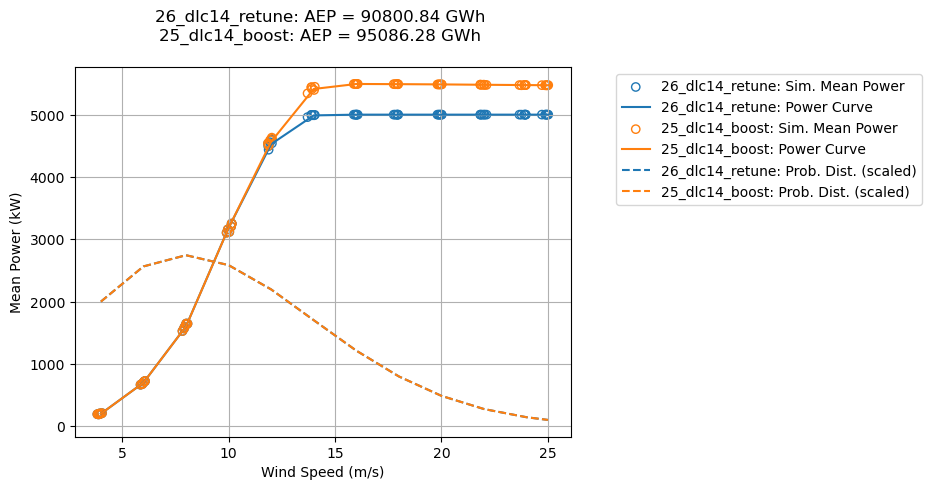

In [6]:
plot_aep(aep_info, ss, cm, labels)

# Damage Equivalent Loads
The DEL is calculated for each simulation, along with the lifetime DEL, weighted by the wind speed distribution.

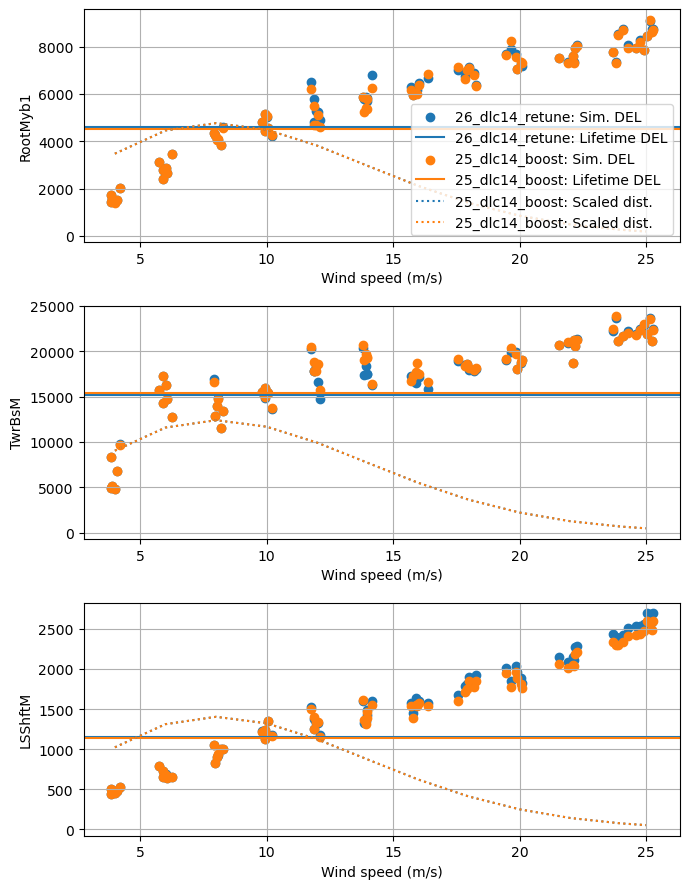

In [7]:
###########################################################################################################


cases = [index for index, element in enumerate(dd[0].index) if '1.1' in element]
cases = dd[0].index[cases]

dp, dws = plot_dels_at_ws(dd, ss, ds, cases=cases, channels=del_channels, labels=labels)

# Characteristic Loads
Extreme load processing:

For each mean wind speed, we take the mean of the maximum load; this is plotted below.  The maximum of these means in the characteristic load.

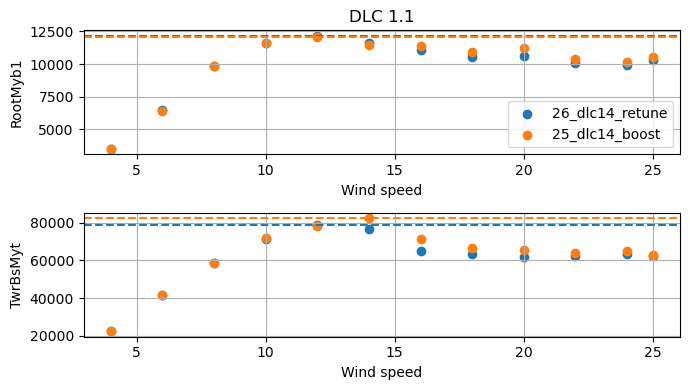

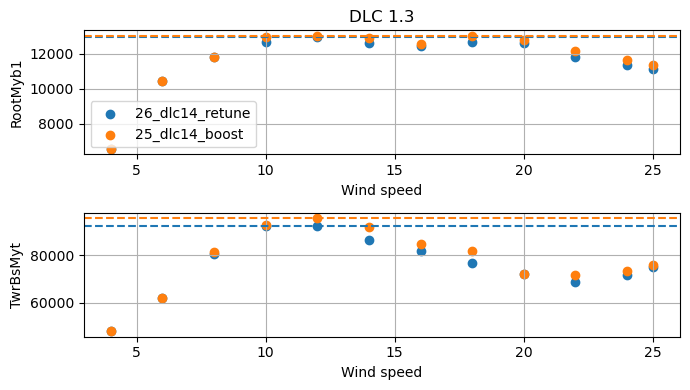

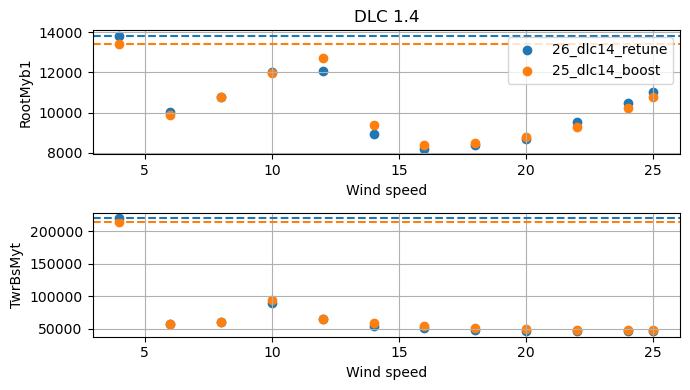

In [8]:

###########################################################################################################

_,_ = plot_characteristic_loads(char_loads, char_load_cases, channels=char_load_channels, labels=labels)

# Binned data (all cases)
Binning is performed by taking the average of the channel over the specified time window.

Text(0.5, 0.98, 'All binned data. Window = 20.0 sec.')

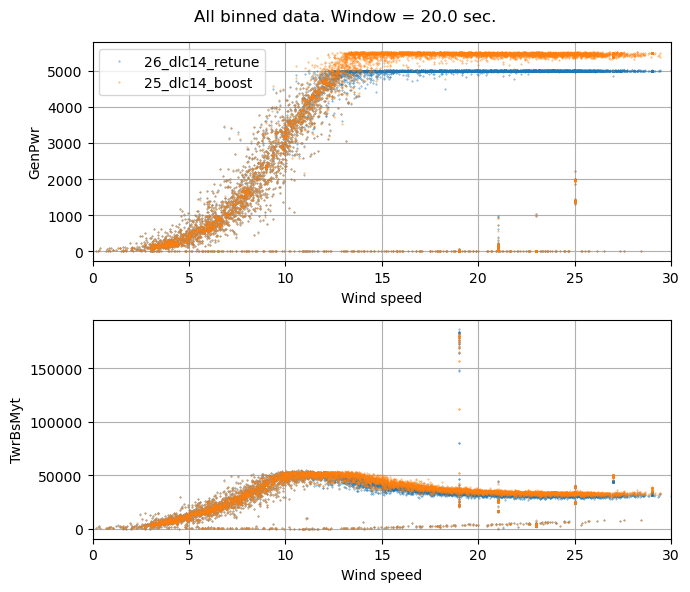

In [9]:
bin_channels = ['GenPwr','TwrBsMyt']

###########################################################################################################

bin_dfs = []
for summary_folder in summary_folders:
    bin_dfs.append(pd.read_pickle(os.path.join(summary_folder,'binned_all.p')))

fig, axs, dt = plot_binned_data(bin_dfs, channels=bin_channels, fig=None, labels=labels)
fig.suptitle(f'All binned data. Window = {dt} sec.')

# Binned data (by DLC)

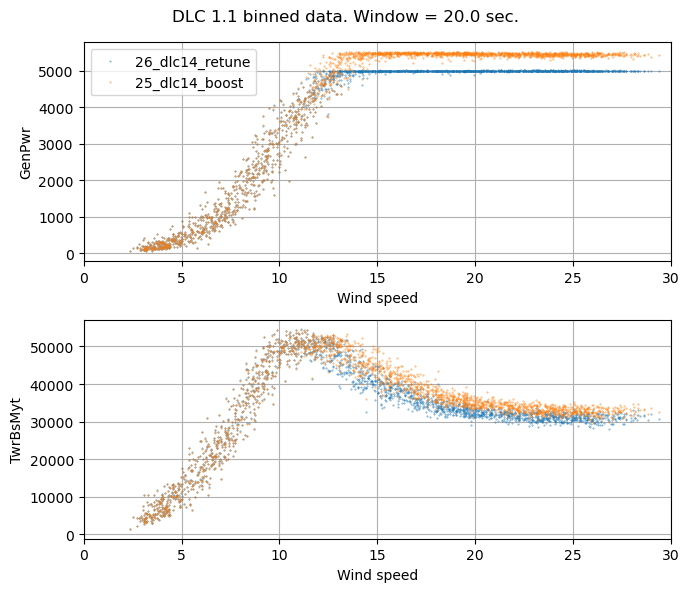

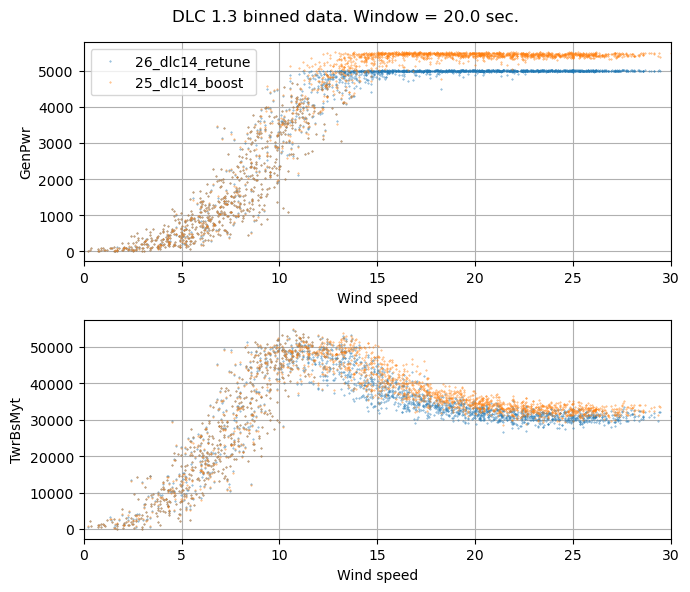

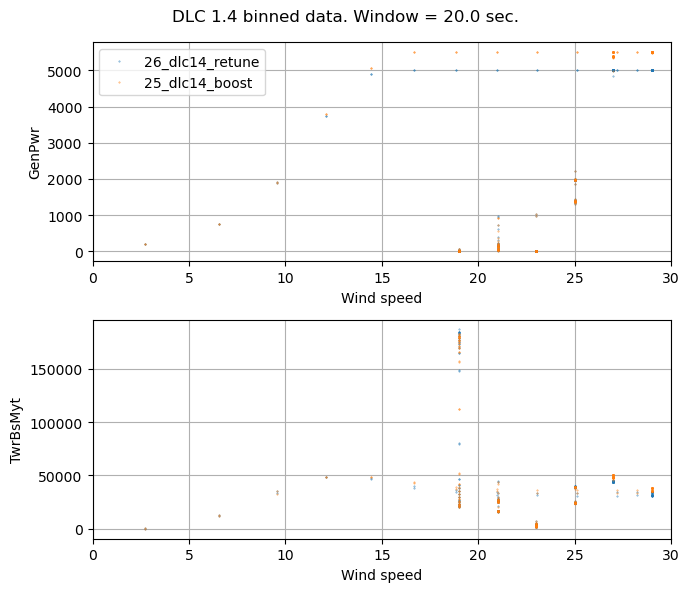

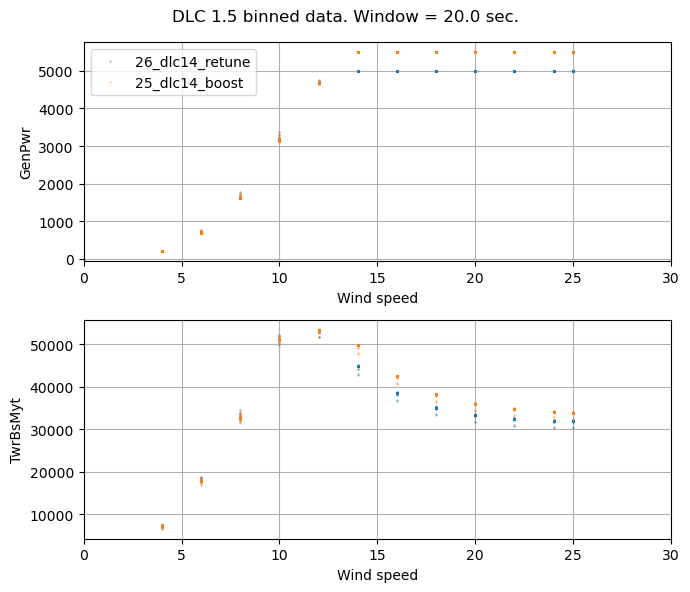

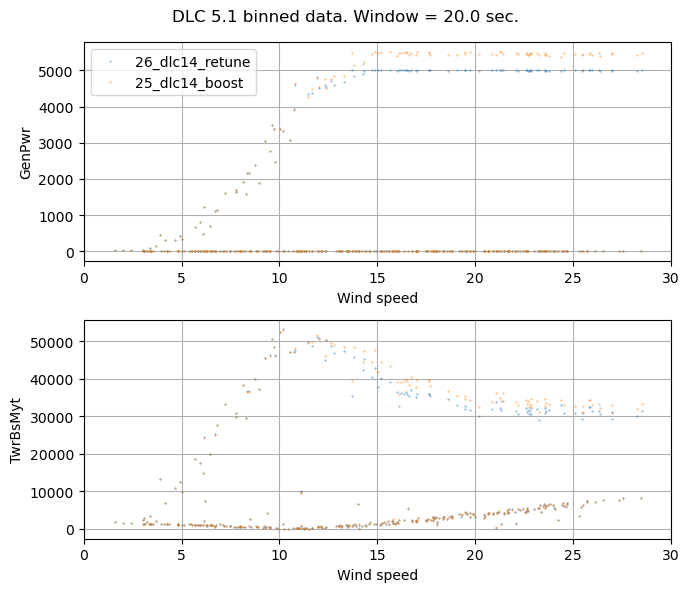

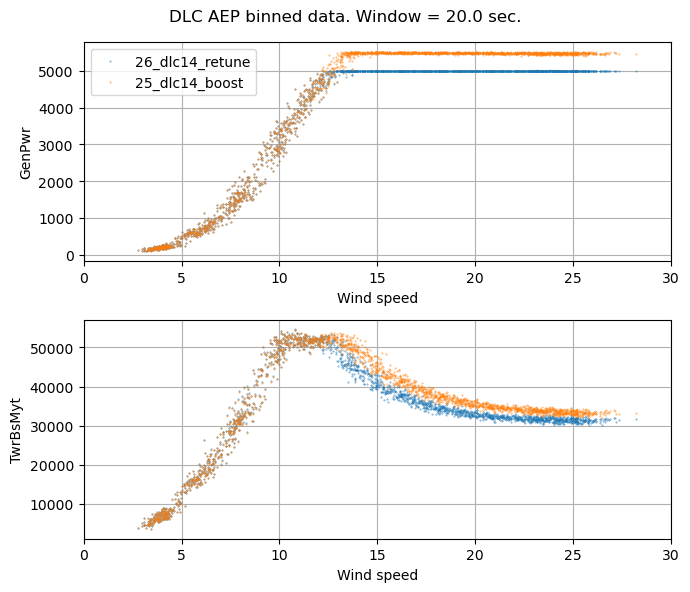

In [10]:
skip_binning = ['Ramp','Steady','Gust','Step']   # These timeseries are plotted, so no need to bin

for dlc in unique_dlcs:
    if dlc in skip_binning:
        continue
    bin_dfs = []
    for summary_folder in summary_folders:
        bin_dfs.append(pd.read_pickle(os.path.join(summary_folder,f'binned_dlc{dlc}.p')))

    fig, axs, dt = plot_binned_data(bin_dfs, channels=bin_channels, fig=None, labels=labels)
    fig.suptitle(f'DLC {dlc} binned data. Window = {dt} sec.')




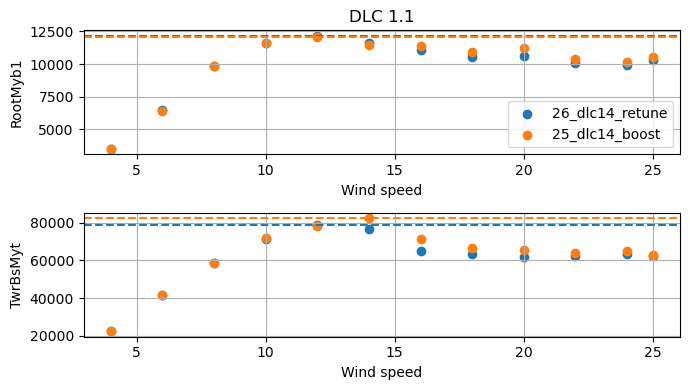

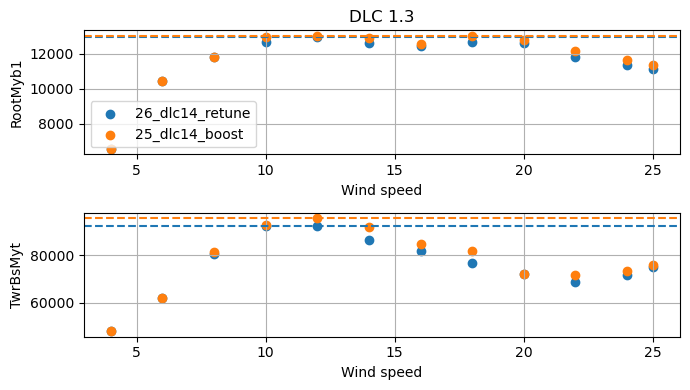

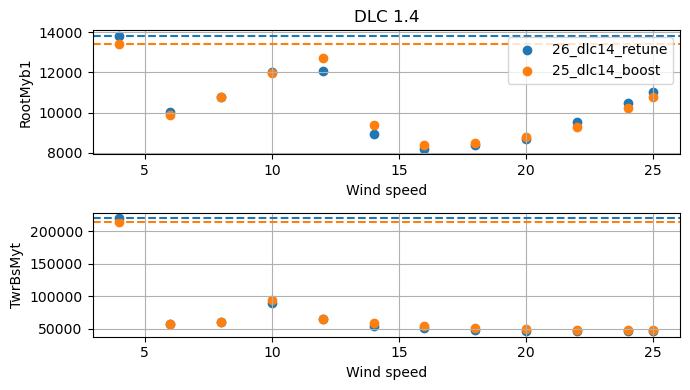

In [11]:

###########################################################################################################

_,_ = plot_characteristic_loads(char_loads, char_load_cases, channels=char_load_channels, labels=labels)

# Plot Stability Cases

for chan = GenTq_[kN-m], overshoot is 15.370156273763019, risetime is 217.675
for chan = BldPitch1_[deg], overshoot is nan, risetime is 0.0
for chan = RtSpeed_[rpm], overshoot is 7.209628055657796, risetime is 205.18124999999998


/tmp/ipykernel_7357/147576342.py:269: RuntimeWarning: invalid value encountered in scalar divide
  overshoot = (np.max(y) - yss) / yss * 100


for chan = GenTq_[kN-m], overshoot is 5.362942312454336, risetime is 207.54375000000005
for chan = BldPitch1_[deg], overshoot is 108.69063918162195, risetime is 1.9437500000000227
for chan = RtSpeed_[rpm], overshoot is 4.0804696986940145, risetime is 0.0
for chan = GenTq_[kN-m], overshoot is 0.588025007118419, risetime is 201.3
for chan = BldPitch1_[deg], overshoot is 40.131615141127654, risetime is 201.1125
for chan = RtSpeed_[rpm], overshoot is 1.9736722166833203, risetime is 0.0
for chan = GenTq_[kN-m], overshoot is 0.6398860947036433, risetime is 0.0
for chan = BldPitch1_[deg], overshoot is 5.1859062630335195, risetime is 0.0
for chan = RtSpeed_[rpm], overshoot is 2.5286035502187425, risetime is 0.0
for chan = GenTq_[kN-m], overshoot is 15.349286769288554, risetime is 217.6875
for chan = BldPitch1_[deg], overshoot is 0.0, risetime is 0.0
for chan = RtSpeed_[rpm], overshoot is 7.184643265549277, risetime is 205.18124999999998
for chan = GenTq_[kN-m], overshoot is 5.440204536585041, 

/projects/weis/dzalkind/envs/weis-dlcs/lib/python3.12/site-packages/IPython/core/events.py:82: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)


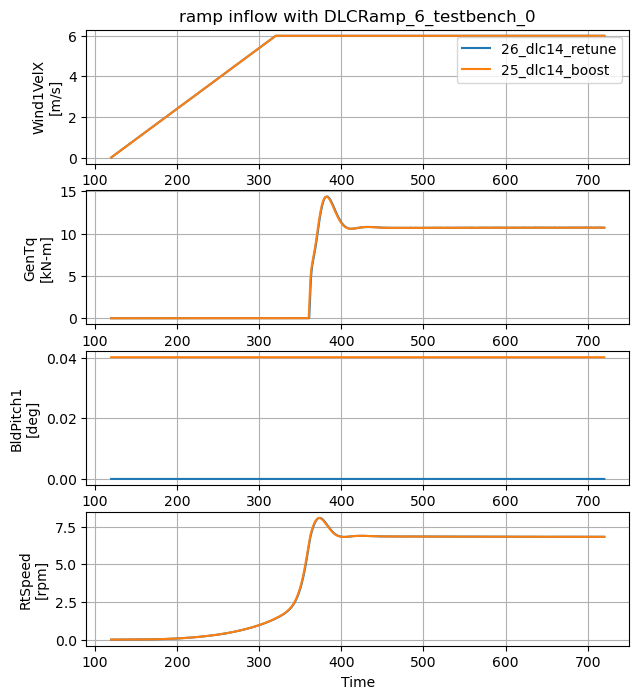

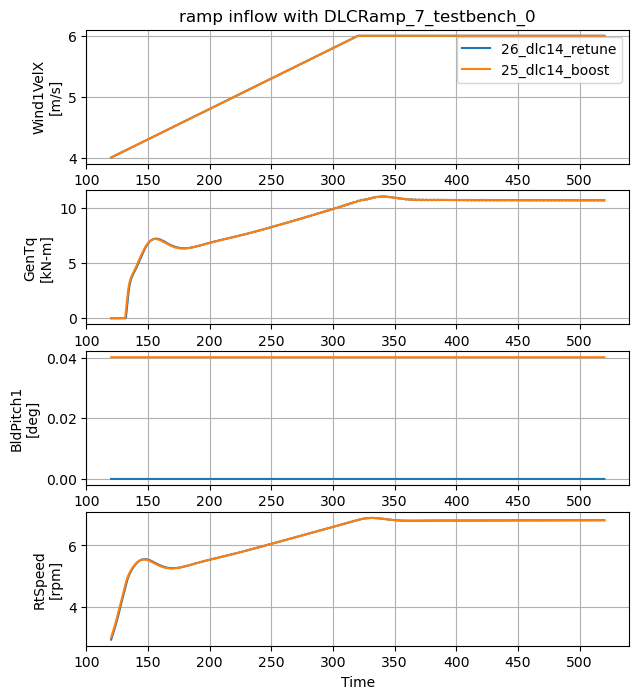

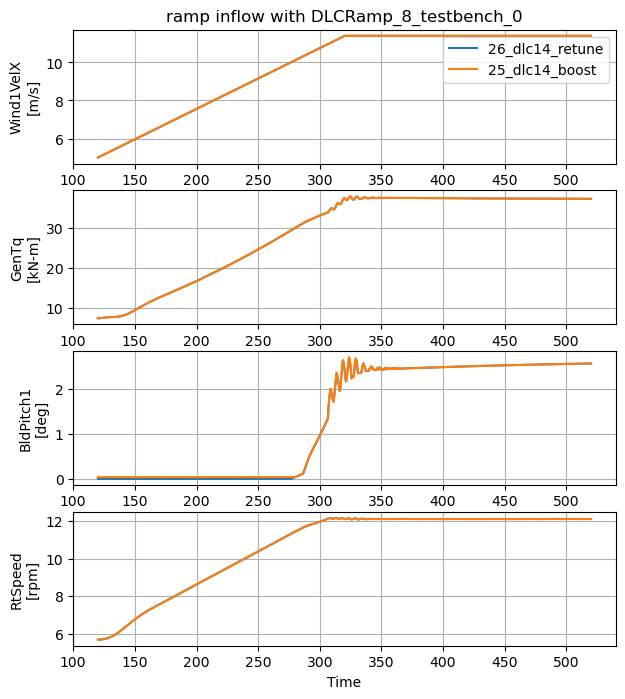

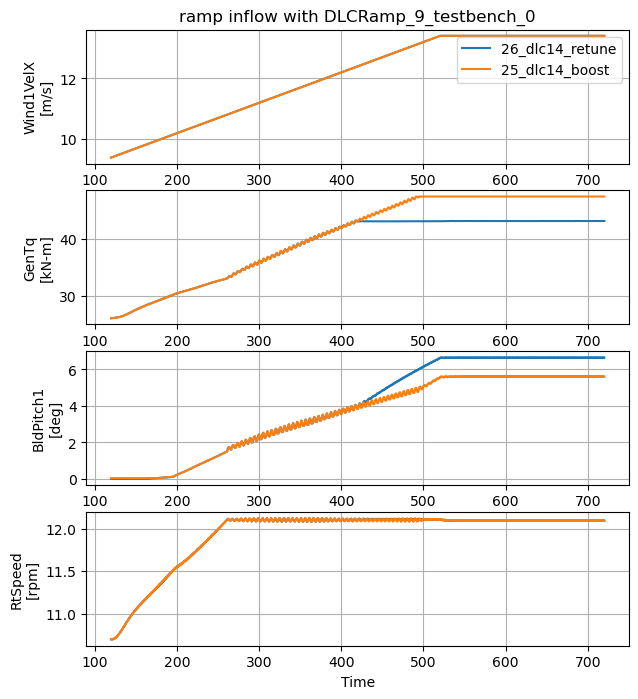

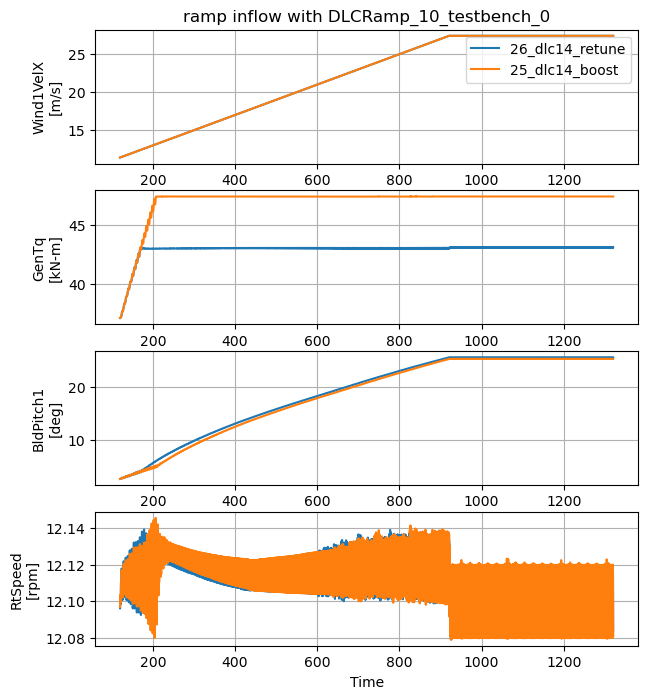

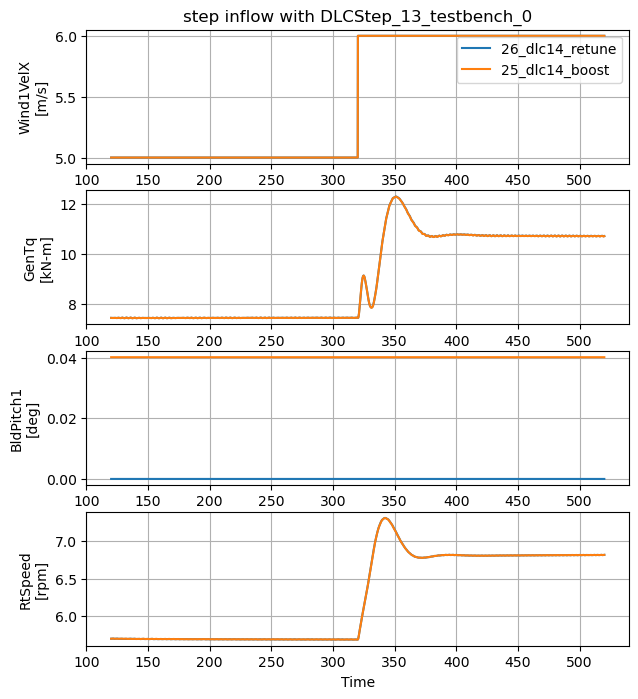

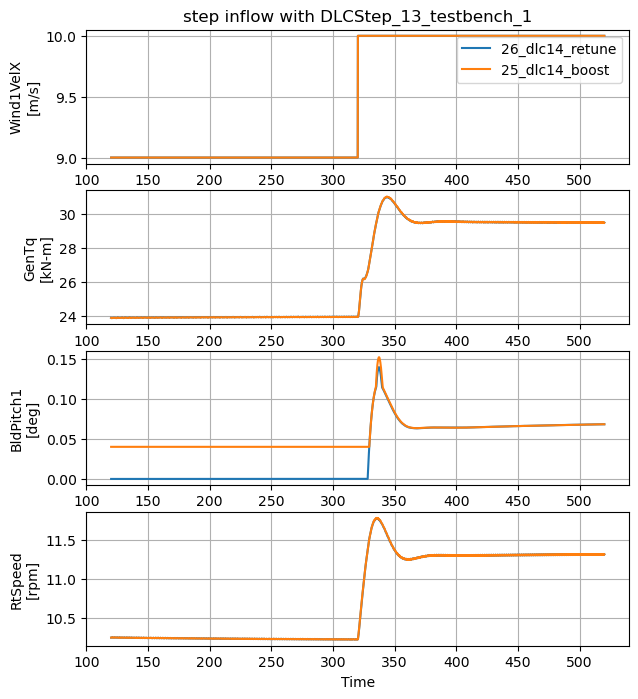

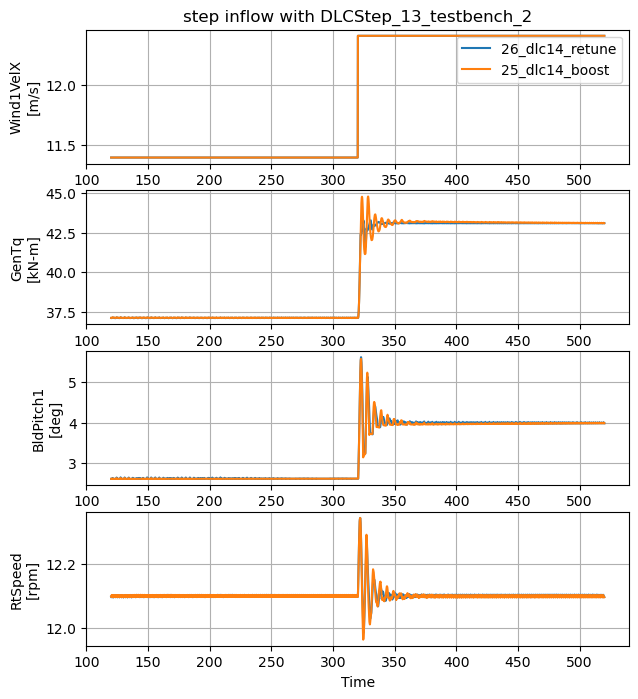

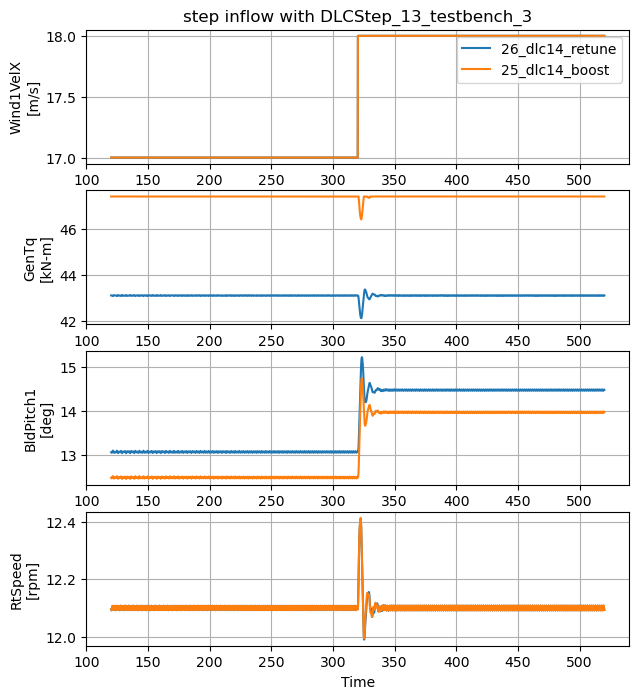

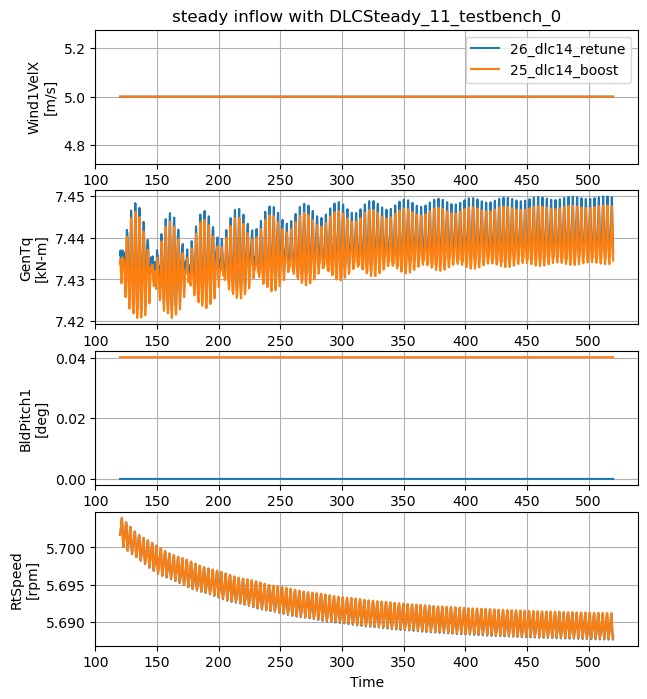

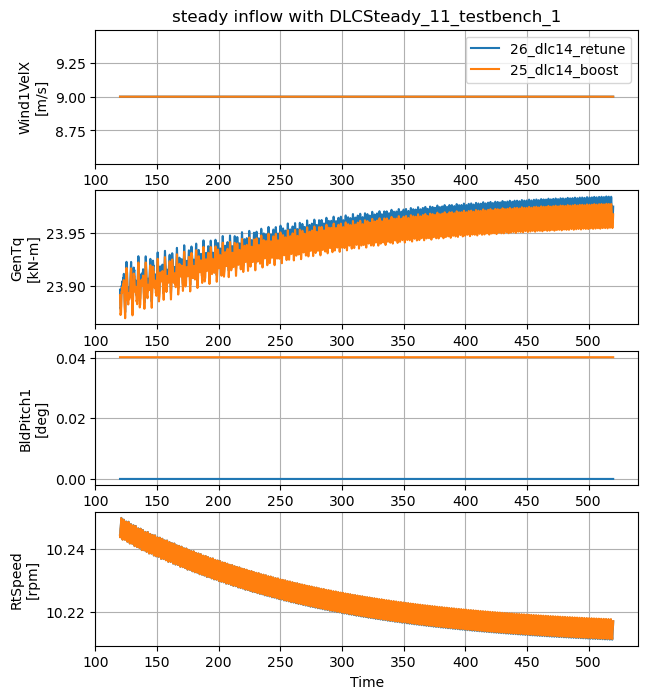

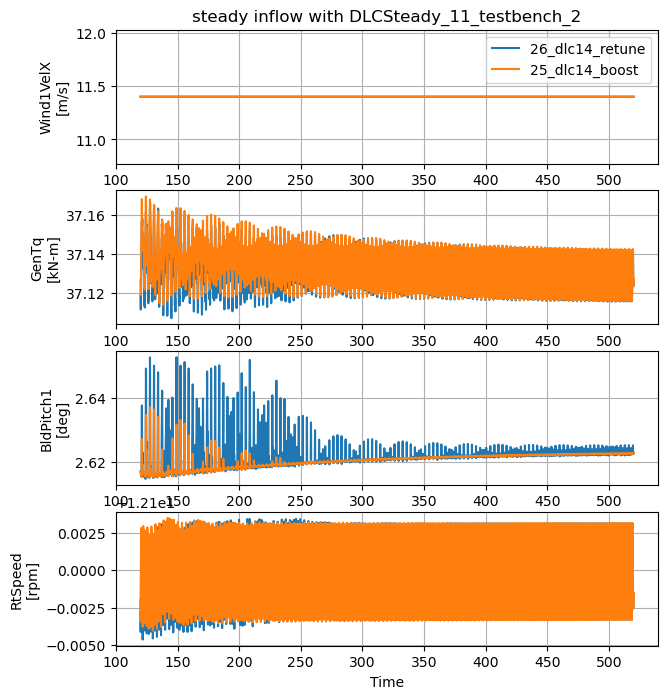

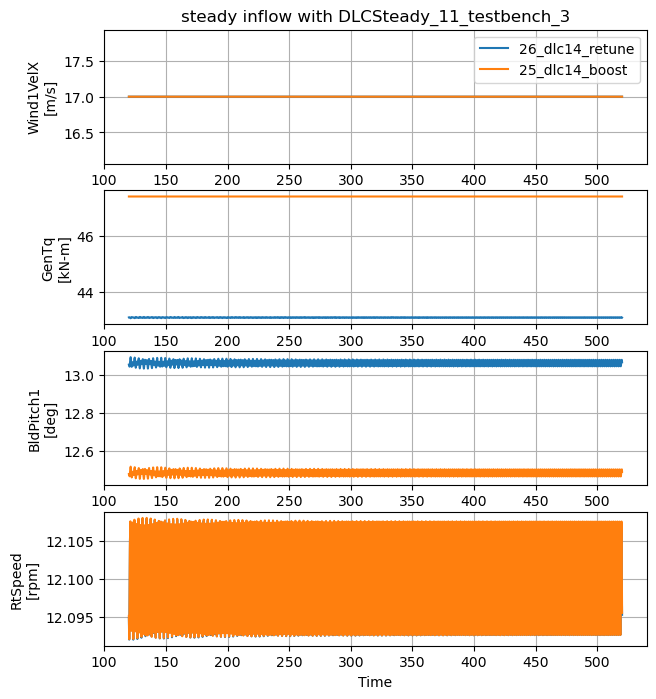

In [12]:

###############################################################################################################

stability_analysis(summary_folders,cm,labels)


# Timeseries Plotting
Plot the `channels` of the timeseries `cases_to_plot`

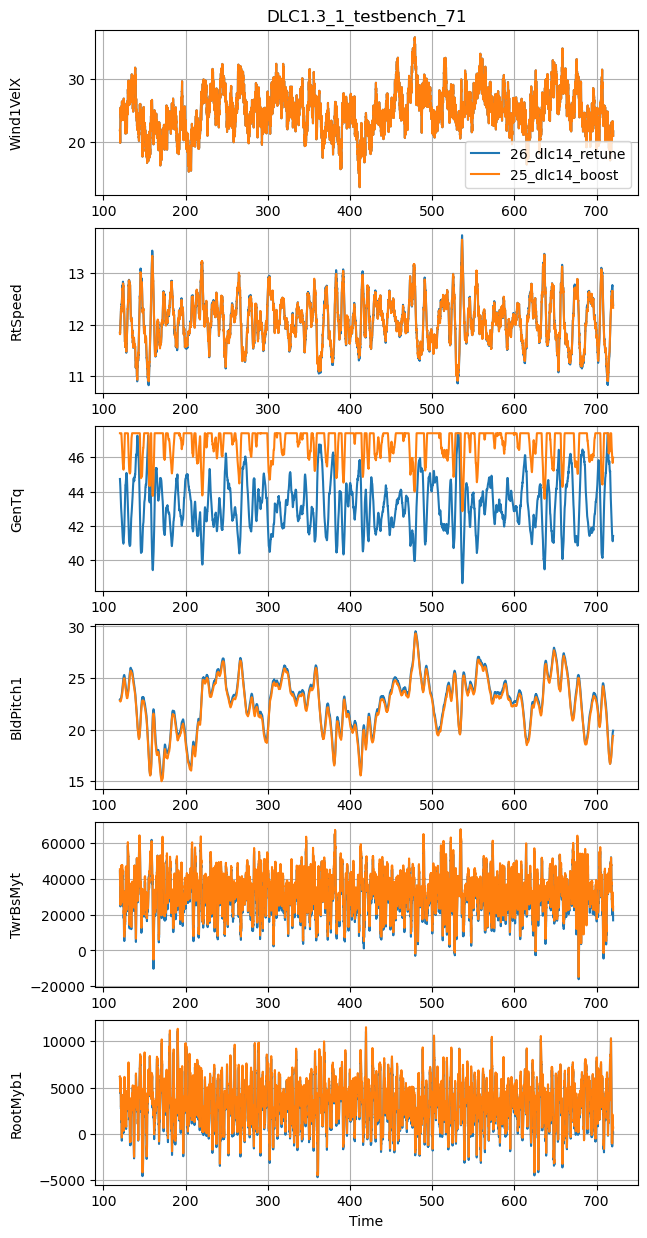

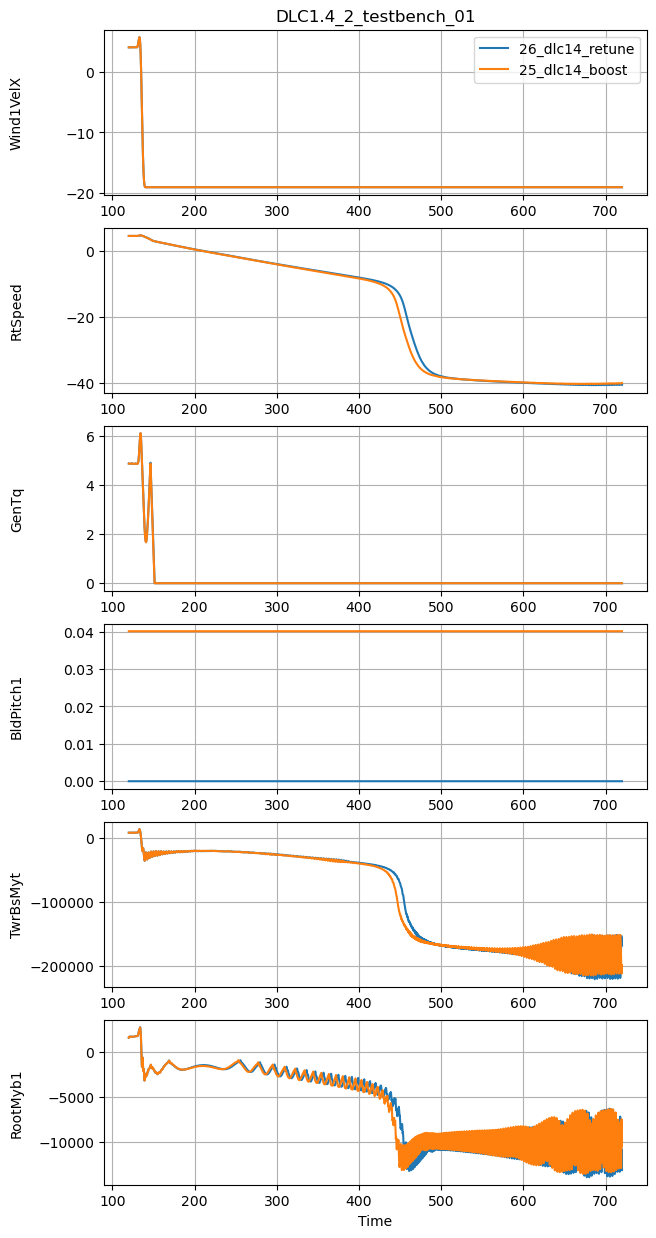

In [13]:
cases_to_plot = ['DLC1.3_1_testbench_71','DLC1.4_2_testbench_01'] 
channels = ['Wind1VelX','RtSpeed','GenTq', 'BldPitch1','TwrBsMyt','RootMyb1']

#######################################################################

plot_timeseries(summary_folders,cases_to_plot, channels,labels)

# Frequency Measures
The output contains the
1. N largest PSDs for each `psd_channels` and frequency domain specified in the `testbench_options.yaml`
2. PSD comparison between controllers



In [14]:
channels_to_analyze = ['TwrBsMyt','RootMyb1','BldPitch1']
n_largest = 4
sort_index = 0  # index of the label to sort by, e.g. 0 for 'ROSCO', 1 for 'ROSCO+Boost', etc.

#############################################################################

psd_summ = []
for summary_folder in summary_folders:
    psd_summ.append(pd.read_pickle(os.path.join(summary_folder,'psd_summary.p')))

report_psd_ranking(psd_summ,channels_to_analyze,n_largest)

            


4 highest cases for TwrBsMyt at f = [0.18149, 0.221826]
                       26_dlc14_retune  25_dlc14_boost
case_name                                             
DLC1.4_2_testbench_02      25102508.03     71400982.86
DLC1.3_1_testbench_08      23663660.95     43965899.65
DLC1.3_1_testbench_06      20953208.60     38658486.75
DLC1.4_2_testbench_06      20104911.33     35094774.37

4 highest cases for TwrBsMyt at f = [0.54448, 0.66547]
                       26_dlc14_retune  25_dlc14_boost
case_name                                             
DLC1.4_2_testbench_02      25102508.03     71400982.86
DLC1.3_1_testbench_08      23663660.95     43965899.65
DLC1.3_1_testbench_06      20953208.60     38658486.75
DLC1.4_2_testbench_06      20104911.33     35094774.37

4 highest cases for RootMyb1 at f = [0.18149, 0.221826]
                       26_dlc14_retune  25_dlc14_boost
case_name                                             
DLC1.4_2_testbench_02      25102508.03     71400982.86
DLC1.3

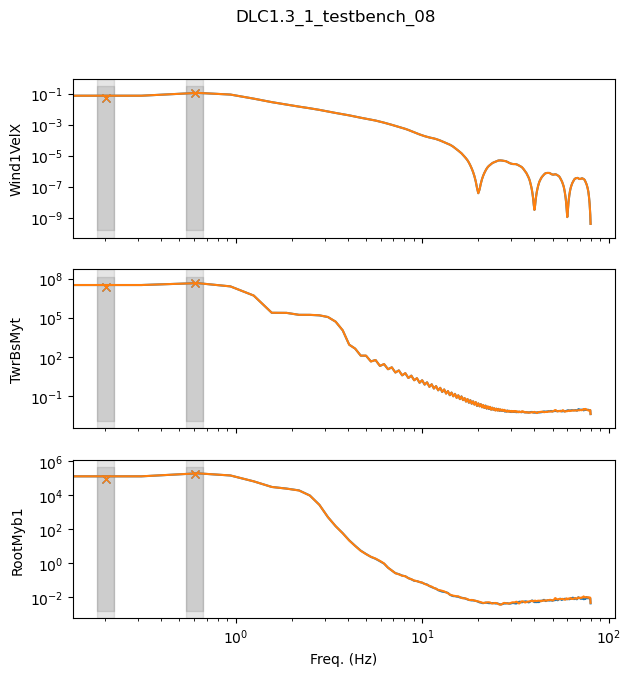

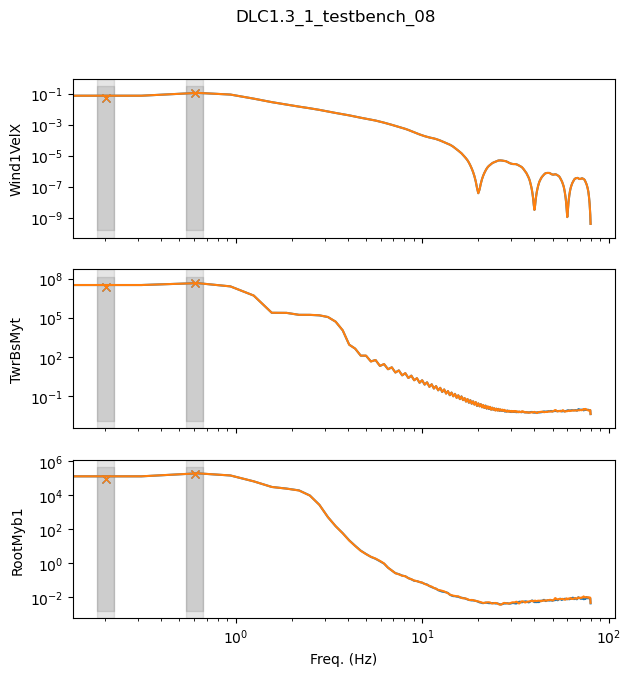

In [15]:
cases_to_plot = ['DLC1.3_1_testbench_08','DLC1.3_1_testbench_08'] 
channels = ['Wind1VelX','TwrBsMyt','RootMyb1']


#############################################################################

plot_psd_comparison(summary_folders, cases_to_plot, channels)



# User Playground
Identify worst cases, compute measures using
- `ss` list of summary stats for each controller
- `dd` list of DELs for each controller

In [ ]:
# Find the cases with the largest tower loads
ss[0]['TwrBsMyt']['abs'].sort_values(ascending=False).head(10)

DLC1.4_2_testbench_01.outb    220468.65
DLC1.4_2_testbench_00.outb    218901.17
DLCGust_12_testbench_2.outb   129968.10
DLC1.3_1_testbench_20.outb    108372.74
DLC1.3_1_testbench_25.outb    106415.33
DLCGust_12_testbench_3.outb   104317.48
DLC1.3_1_testbench_29.outb    102630.46
DLC1.4_2_testbench_06.outb     99131.80
DLC1.3_1_testbench_19.outb     97796.73
DLC1.3_1_testbench_27.outb     94766.95
Name: abs, dtype: float64